In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import verde as vd
import harmonica as hm

The following is the basic upward continuation example from [the docs](https://www.fatiando.org/harmonica/latest/gallery/eql/harmonic.html#sphx-glr-gallery-eql-harmonic-py).

As you can see, it interpolates point data, while upward continuing it. The goal will be to extract this and throw it into GemPy to construct a model.

In [2]:
# Fetch the sample total-field magnetic anomaly data from Great Britain
data = hm.datasets.fetch_britain_magnetic()
data

,survey_area,line-number-segment,longitude,latitude,altitude_m,total_field_anomaly_nt
0,CA55_NORTH,FL1-1,-1.74162,53.48164,842.0,62
1,CA55_NORTH,FL1-1,-1.70123,53.48352,713.0,56
2,CA55_NORTH,FL1-1,-1.08051,53.47676,364.0,30
3,CA55_NORTH,FL1-1,-1.07471,53.47672,364.0,31
4,CA55_NORTH,FL1-1,-1.01762,53.47586,370.0,44
...,...,...,...,...,...,...
541503,HG65,FL-3(TL10-24)-1,-4.68843,58.26786,1084.0,64
541504,HG65,FL-3(TL10-24)-1,-4.68650,58.26787,1098.0,74
541505,HG65,FL-3(TL10-24)-1,-4.68535,58.26790,1088.0,94
541506,HG65,FL-3(TL10-24)-1,-4.68419,58.26787,1077.0,114


In [3]:
# Slice a smaller portion of the survey data to speed-up calculations for this
# example
region = [-5.5, -4.7, 57.8, 58.5]
inside = vd.inside((data.longitude, data.latitude), region)
data = data[inside]
print("Number of data points:", data.shape[0])
print("Mean height of observations:", data.altitude_m.mean())

Number of data points: 7054
Mean height of observations: 541.8293166997448


In [4]:
# Since this is a small area, we'll project our data and use Cartesian
# coordinates
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
coordinates = (easting, northing, data.altitude_m)

In [5]:
# Create the equivalent layer. We'll use the default point source configuration
# at a constant relative depth beneath each observation point. The damping
# parameter helps smooth the predicted data and ensure stability.
eql = hm.EQLHarmonic(relative_depth=1000, damping=1)

In [6]:
# Fit the layer coefficients to the observed magnetic anomaly.
eql.fit(coordinates, data.total_field_anomaly_nt)

EQLHarmonic(damping=1, relative_depth=1000)

In [7]:
# Evaluate the data fit by calculating an R² score against the observed data.
# This is a measure of how well layer the fits the data NOT how good the
# interpolation will be.
print("R² score:", eql.score(coordinates, data.total_field_anomaly_nt))

R² score: 0.9988789670714453


In [8]:
# Interpolate data on a regular grid with 500 m spacing. The interpolation
# requires an extra coordinate (upward height). By passing in 1500 m, we're
# effectively upward-continuing the data (mean flight height is 500 m).
grid = eql.grid(spacing=500, data_names=["magnetic_anomaly"], extra_coords=1500)

In [9]:
# The grid is a xarray.Dataset with values, coordinates, and metadata
print("\nGenerated grid:\n", grid)


Generated grid:
 <xarray.Dataset>
Dimensions:           (easting: 95, northing: 157)
Coordinates:
  * easting           (easting) float64 -3.24e+05 -3.235e+05 ... -2.769e+05
  * northing          (northing) float64 4.175e+06 4.176e+06 ... 4.253e+06
    extra_coord       (northing, easting) float64 1.5e+03 1.5e+03 ... 1.5e+03
Data variables:
    magnetic_anomaly  (northing, easting) float64 30.67 30.73 ... 161.3 149.9
Attributes:
    metadata:  Generated by EQLHarmonic(damping=1, relative_depth=1000)


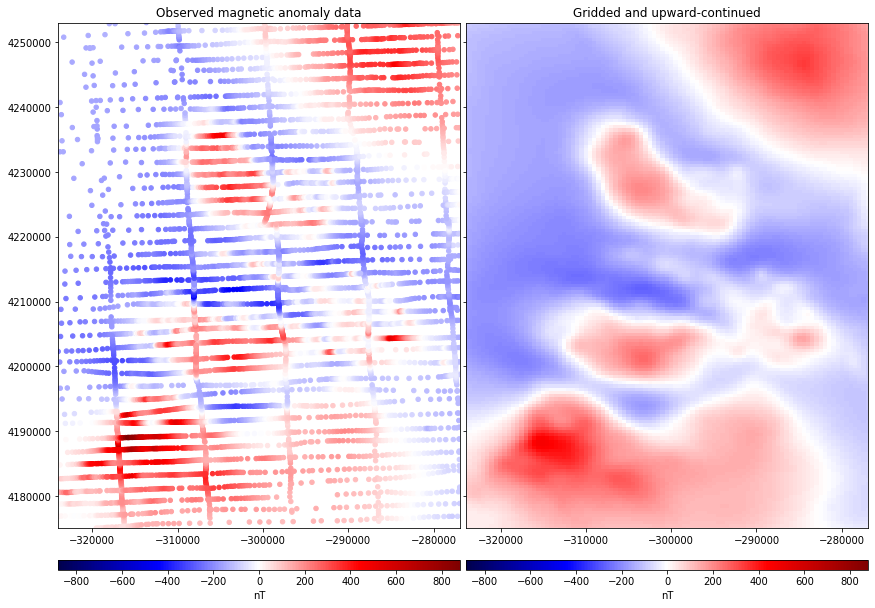

In [10]:
# Plot original magnetic anomaly and the gridded and upward-continued version
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 9), sharey=True)

# Get the maximum absolute value between the original and gridded data so we
# can use the same color scale for both plots and have 0 centered at the white
# color.
maxabs = vd.maxabs(data.total_field_anomaly_nt, grid.magnetic_anomaly.values)

ax1.set_title("Observed magnetic anomaly data")
tmp = ax1.scatter(
    easting,
    northing,
    c=data.total_field_anomaly_nt,
    s=20,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp, ax=ax1, label="nT", pad=0.05, aspect=40, orientation="horizontal")
ax1.set_xlim(easting.min(), easting.max())
ax1.set_ylim(northing.min(), northing.max())

ax2.set_title("Gridded and upward-continued")
tmp = grid.magnetic_anomaly.plot.pcolormesh(
    ax=ax2,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp, ax=ax2, label="nT", pad=0.05, aspect=40, orientation="horizontal")
ax2.set_xlim(easting.min(), easting.max())
ax2.set_ylim(northing.min(), northing.max())

plt.tight_layout(pad=0)
plt.show()

## New stuff

Our `grid` object is a xarray `Dataset`. This means that we can easily do anything that one can do with xarray with our grid. That includes writing to file:

In [11]:
type(grid)

xarray.core.dataset.Dataset

The recommended way (http://xarray.pydata.org/en/stable/io.html) is to save as a `.nc` (NetCDF) file.

In [12]:
fname = '../data/fatiando_gridded_data'
grid.to_netcdf(fname + '.nc')

C:\Users\mtb\Miniconda3\envs\new_fatiando\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Since we want to go to GemPy, which at present does not have facility for NetCDF import, we will have to use something that pandas understands. Luckily we can easily convert the `Dataset` to a `DataFrame`:

In [13]:
grid.to_dataframe()

magnetic_anomaly  extra_coord
easting        northing                                   
-324002.139135 4.175068e+06         30.667677       1500.0
               4.175568e+06         30.405465       1500.0
               4.176067e+06         30.265085       1500.0
               4.176567e+06         30.310932       1500.0
               4.177067e+06         30.669662       1500.0
...                                       ...          ...
-276890.268483 4.251041e+06        172.457827       1500.0
               4.251541e+06        168.851813       1500.0
               4.252040e+06        163.476307       1500.0
               4.252540e+06        156.952806       1500.0
               4.253040e+06        149.937658       1500.0

[14915 rows x 2 columns]

which allows us to save it as a `csv` file:

In [14]:
grid.to_dataframe().to_csv(fname + '.csv')